# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Необходимо ответить на вопросы:

- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

**Содержание:**
- [изучение общей информации](#1)
- [предобработка данных](#2)
- [ответы на поставленные вопросы](#3)
- [общий вывод и рекомендации](#4)

<a id='1'></a>
## Шаг 1. Откройте файл с данными и изучите общую информацию

In [255]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem()

In [256]:
df = pd.read_csv("/datasets/data.csv")

In [257]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [259]:
df.duplicated().sum()

54

На этапе предобработки данных нам предстоит:
- разобраться с null-значениями в столбцах days_employed, total_income, причем их количество в обоих столбцах одинаково
- в таблице уже есть 2 колонки со значениями id некоторых категорий, некоторым колонкам так же можно дать id, а другим предстоит категоризация данных, после чего можно будет уменьшить число колонок в таблице.
- отрицательные значения трудового стажа
- разные регистры букв в колонке education
- обработать найденные и проверить наличие неявных дупликатов

<a id='2'></a>
## Шаг 2. Предобработка данных

### Обработка пропусков

Постараемся выяснить, с чем связаны пропуски в этих столбцах. Возможно определенный тип занятости их не заполняет, либо люди молодого возраста, которые даже не начинали работать.

In [260]:
# получаю таблицу, где "days_employed" = NaN, и подтверждаем, что в этих же строках пропущен "total_income"
df_isnan = df[df["days_employed"].isna()] 
df_isnan

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


2174 строк с пропусками, что составляет около 10% строк во всей таблице. Изучим их подробнее.

In [261]:
# сравниваю распределение по типу занятости всего датафрейма с выборкой, в которой стаж и доход не указаны
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [262]:
df_isnan['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Нельзя сказать, что пропуски пресуще определнному типу занятости. И даже наоборот, возникает ощущение, что кто-то специально убрал по 10% значений стажа и дохода из выборок по типу занятости)

(array([ 10.,   0.,  24., 275., 407., 398., 398., 366., 235.,  61.]),
 array([ 0. ,  7.3, 14.6, 21.9, 29.2, 36.5, 43.8, 51.1, 58.4, 65.7, 73. ]),
 <a list of 10 Patch objects>)

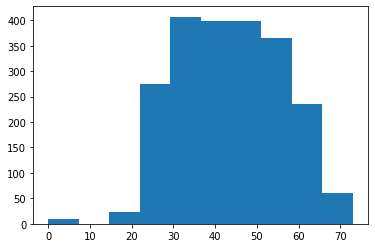

In [263]:
# сравниваю распределение по возрасту всего датафрейма с выборкой, в которой стаж и доход не указаны
plt.hist(df_isnan['dob_years'])

(array([ 101.,    0.,  359., 2824., 4503., 4044., 3944., 3233., 2162.,
         355.]),
 array([ 0. ,  7.5, 15. , 22.5, 30. , 37.5, 45. , 52.5, 60. , 67.5, 75. ]),
 <a list of 10 Patch objects>)

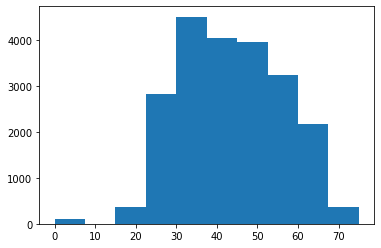

In [264]:
plt.hist(df['dob_years'])

Так-же нельзя сказать, что пропуски пресуще определенному возрасту. *Делаем вывод, что пропуски ровно распределены по всей генеральной совокупности и их удаление не приведет к значительным искажениям (предположу, что это люди неофициально оформлены по месту работы).*
Так же можно заменить пропуски значением 0, но нужно проверить, нет ли уже таких значений в ген. совокупности, что-бы они не смешались.
Еще мы видим, что есть группа людей, возраст которых около нуля. Проверим их в дальнейшем.

In [265]:
# заменяю колонку days_employed на employed_years
df["employed_years"] = df["days_employed"] / 365
df = df.drop(['days_employed'], axis=1)
df

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,-23.116912
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,-11.026860
2,0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,-15.406637
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,-11.300677
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,932.235814
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,-12.409087
21521,0,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,942.294258
21522,1,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,-5.789991
21523,3,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,-8.527347


(array([15906.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         1483.,  1962.]),
 array([ -50.38068466,   64.72735654,  179.83539774,  294.94343894,
         410.05148014,  525.15952134,  640.26756253,  755.37560373,
         870.48364493,  985.59168613, 1100.69972733]),
 <a list of 10 Patch objects>)

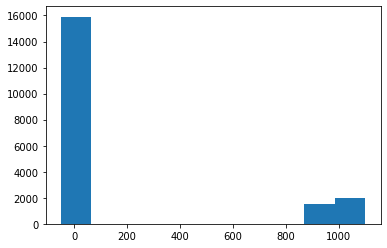

In [266]:
# распределение по стажу в годах
plt.hist(df['employed_years'])
# мы уже видели наличие отрицательных значений в стаже, теперь еще увидели аномалии со стажем около 1000 лет

In [267]:
# проверяем наличие значений 0 в employed_years
df[df['employed_years'] == 0]['employed_years'].count()

0

In [268]:
df[df['total_income'] == 0]['total_income'].count()

0

In [269]:
# заменяем NaN на 0
df['employed_years'] = df['employed_years'].fillna(0)
df['total_income'] = df['total_income'].fillna(0)
df.isnull().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
employed_years      0
dtype: int64

In [270]:
# есть ли вообще адекватные записи стажа?
(df[(df['employed_years'] < 100) & (df['employed_years'] > 0)]['employed_years'].count())
# нет)

0

In [271]:
# просто проверяю себя на общее кол-во записей
(df[ df['employed_years'] <= 0]['employed_years'].count()) + (df[ df['employed_years'] > 100]['employed_years'].count())

21525

(array([3.000e+00, 1.200e+01, 4.400e+01, 1.110e+02, 1.950e+02, 3.790e+02,
        6.520e+02, 1.686e+03, 4.085e+03, 8.739e+03]),
 array([-50.38068466, -45.34923034, -40.31777602, -35.2863217 ,
        -30.25486738, -25.22341306, -20.19195874, -15.16050442,
        -10.1290501 ,  -5.09759578,  -0.06614146]),
 <a list of 10 Patch objects>)

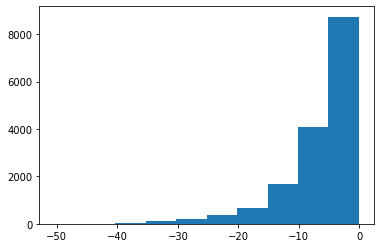

In [272]:
# проверим отрицательные значения по стажу
employed_negative = df[df["employed_years"] < 0]
plt.hist(employed_negative['employed_years'])

In [273]:
# распределение значений логичны, так что просто поменяем им знак и сделаем положительными
df["employed_years"] = df["employed_years"].abs()
# проверяем, сработал ли abs()
df[ df['employed_years'] < 0]['employed_years'].count()

0

In [274]:
# проверим у кого стаж окодо 1000 лет
df_employ_1000 = df[ df['employed_years'] > 100]
df_employ_1000
# видим что это пенсионеры

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,932.235814
18,0,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля,1096.660649
24,1,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью,927.539597
25,0,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости,996.023258
30,1,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью,919.401832
...,...,...,...,...,...,...,...,...,...,...,...,...
21505,0,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439.993167,сыграть свадьбу,928.506483
21508,0,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638.590915,недвижимость,1058.897847
21509,0,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029.059379,операции с недвижимостью,992.222066
21518,0,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем,1024.645783


In [275]:
# проверим, все ли они пенсионеры
df_employ_1000['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

In [276]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [277]:
# есть ли пенсионеры с адекватным стажем?
df[( df['employed_years'] < 100) & (df['income_type'] == "пенсионер")]

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
12,0,65,среднее,1,гражданский брак,1,M,пенсионер,0,0.0,сыграть свадьбу,0.0
29,0,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,0.0,строительство жилой недвижимости,0.0
55,0,54,среднее,1,гражданский брак,1,F,пенсионер,1,0.0,сыграть свадьбу,0.0
67,0,52,высшее,0,женат / замужем,0,F,пенсионер,0,0.0,покупка жилья для семьи,0.0
145,0,62,среднее,1,женат / замужем,0,M,пенсионер,0,0.0,строительство недвижимости,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21311,0,49,среднее,1,женат / замужем,0,F,пенсионер,0,0.0,покупка жилья для сдачи,0.0
21321,0,56,Среднее,1,женат / замужем,0,F,пенсионер,0,0.0,операции с недвижимостью,0.0
21414,0,65,среднее,1,женат / замужем,0,F,пенсионер,0,0.0,покупка своего жилья,0.0
21415,0,54,среднее,1,женат / замужем,0,F,пенсионер,0,0.0,операции с жильем,0.0


In [278]:
# складываем пенсионеров со стажем 0 (их 413) и стажем около 1000 (их 3443) = 3856 (столько пенсионеров всего)
df[( df['employed_years'] == 0) & (df['income_type'] == "пенсионер")]['income_type'].count() + 3443

3856

Ни одной адекватной записи стажа у пенсионеров в данных нет, большая их часть составляла Nan, которые мы заменили нулями, а остальная
неадекватно большая (около 1000 лет). Нужно обратить внимание на некорректный сбор данных по категории пенсионеры и безработные.

(вообще я думаю, что в рамках данного проекта и получения ответа на поставленные вопросы большинство столбцов и вовсе не нужны: возраст, образование, пол, тип занятости, стаж - вряд ли сильно помогут нам, но данные у них наиболее проблемные)

In [279]:
# max стаж жействующих сотрудников
df.loc[(df['income_type'] != "пенсионер") &  (df['income_type'] != "безработный")]['employed_years'].max()

50.38068465909146

In [280]:
df[df['income_type'] == "безработный"]

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
3133,1,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи,924.724567
14798,0,45,Высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью,1083.021476


In [281]:
# заменим стаж пенсионеров на 50 лет, а безработных на 0
df.loc[df['income_type'] == "пенсионер", 'employed_years'] = 50
df.loc[df['income_type'] == "безработный", 'employed_years'] = 0
df.loc[df['income_type'] == "пенсионер"].head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,50.0
12,0,65,среднее,1,гражданский брак,1,M,пенсионер,0,0.000000,сыграть свадьбу,50.0
18,0,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля,50.0
24,1,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью,50.0
25,0,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости,50.0


In [282]:
# Люди с возрастом = 0, можно предположить, что это люди до 18 лет, но даже на глаз видно, что среди них есть с 3 детьми,
# пенсионеры. Оставим эти данные, будем считать люди просто незахотели указывать возраст.
df[df['dob_years'] == 0]

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
99,0,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль,50.000000
149,0,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем,7.299379
270,3,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью,5.130584
578,0,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости,50.000000
1040,0,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль,3.172684
...,...,...,...,...,...,...,...,...,...,...,...,...
19829,0,0,среднее,1,женат / замужем,0,F,сотрудник,0,0.000000,жилье,0.000000
20462,0,0,среднее,1,женат / замужем,0,F,пенсионер,0,259193.920299,покупка своего жилья,50.000000
20577,0,0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость,50.000000
21179,2,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости,0.298540


In [283]:
# ну и после всех изменнеий еще раз проверим наличие пропусков
df.isnull().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
employed_years      0
dtype: int64

**Вывод**

Около 10% полей имели пропуски значений дохода и стажа. Анализ показал, что пропуски ровно распределены по всем группам людей разного статуса и возраста. Пропуски заменили нулями, так как эти данные не должны помешать нам на поставленные вопросы, кроме вопроса о зависимости от дохода, при которых поля со значеним 0 мы просто не будем брать в расчет.

### Замена типа данных

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
employed_years      21525 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [285]:
# заменим тип данных с доходом и стажем на int, читабельность повысится, а точность не сильно пострадает
df['total_income'] = df['total_income'].astype(int)
df['employed_years'] = df['employed_years'].astype(int)
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11
2,0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,50


**Вывод**

Заменили тип данных с доходом и стажем с float на int, т.к. читабельность чисел повысится, а точность не сильно пострадает.

### Обработка дубликатов

In [286]:
# кол-во дупликат
df.duplicated().sum()

54

In [287]:
# данные записаны в разных регистрах, можно проверить наличие неявных дупликат
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [288]:
# переведем колонки содержащие строки в нижний регистр
df["education"] = df["education"].str.lower()
df["family_status"] = df["family_status"].str.lower()
df["income_type"] = df["income_type"].str.lower()
df["purpose"] = df["purpose"].str.lower()
df["gender"] = df["gender"].str.lower()

In [289]:
# так лучше)
df['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [290]:
# проверим и другие столбцы на наличие неявных дубликатов и артефактов
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [291]:
df['gender'].value_counts()

f      14236
m       7288
xna        1
Name: gender, dtype: int64

In [292]:
# что такое xna?)))
df[df['gender'] == "xna"]
# данные в строке нормальные, пусть будет xna если так хочется.

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
10701,0,24,неоконченное высшее,2,гражданский брак,1,xna,компаньон,0,203905,покупка недвижимости,6


In [293]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [294]:
# проверим строки, в которых кол-во детей -1 и 20 
df[df['children'] == -1]

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
291,-1,46,среднее,1,гражданский брак,1,f,сотрудник,0,102816,профильное образование,12
705,-1,50,среднее,1,женат / замужем,0,f,госслужащий,0,137882,приобретение автомобиля,2
742,-1,57,среднее,1,женат / замужем,0,f,сотрудник,0,64268,дополнительное образование,8
800,-1,54,среднее,1,не женат / не замужем,4,f,пенсионер,0,86293,дополнительное образование,50
941,-1,57,среднее,1,женат / замужем,0,f,пенсионер,0,0,на покупку своего автомобиля,50
1363,-1,55,среднее,1,женат / замужем,0,f,компаньон,0,69550,профильное образование,3
1929,-1,38,среднее,1,не женат / не замужем,4,m,сотрудник,0,109121,покупка жилья,4
2073,-1,42,среднее,1,в разводе,3,f,компаньон,0,162638,покупка жилья,6
3814,-1,26,среднее,1,гражданский брак,1,f,госслужащий,0,131892,на проведение свадьбы,8
4201,-1,41,среднее,1,женат / замужем,0,f,госслужащий,0,226375,операции со своей недвижимостью,2


In [295]:
df[df['children'] == 20].head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years
606,20,21,среднее,1,женат / замужем,0,m,компаньон,0,145334,покупка жилья,2
720,20,44,среднее,1,женат / замужем,0,f,компаньон,0,112998,покупка недвижимости,2
1074,20,56,среднее,1,женат / замужем,0,f,сотрудник,1,229518,получение образования,9
2510,20,59,высшее,0,вдовец / вдова,2,f,сотрудник,0,264474,операции с коммерческой недвижимостью,7
2941,20,0,среднее,1,женат / замужем,0,f,сотрудник,0,199739,на покупку автомобиля,5


20 детей явная опечатка, т.к. в первой же строке мы видим человека 21 лет. 
Вопрос нам поставлен как влияет ли наличие детей на возврат кредита, а не их кол-во, поэтому оставим 20. А с -1 сложнее, т.к. не понятно как интерпритировать: как 1 или 0, а это уже может исказить итоговый ответ. 
Я решил так же оставить все как есть,  но при ответе на вопрос эти строки с -1 не учитывать.

In [296]:
# появились ли еще дупликаты
df.duplicated().sum()

71

In [297]:
# удаляем дупликаты, сбрасываем индексы
df = df.drop_duplicates().reset_index(drop=True)

In [298]:
# еще раз проверим
df.duplicated().sum()

0

**Вывод**

Несмотря на то, что колонки с уникальным id человека в данных нет, мы обнаружили и удалили 54 дупликатов, так как маловероятно полное совпадение строк, в особенности числовых значений дохода и стажа. Так же выявлены 17 неявных дупликатов, обусловленные записью строк в разных регистрах. Это может быть вызвано отсутсвием единых требований к поступающим данным.

### Лемматизация

In [299]:
# посмотрим на цели кредита
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

In [300]:
# создадим столбец со списком лем от столбца с целью кредита
df['lemmas'] = df['purpose'].apply(lambda text: m.lemmatize(text))
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years,lemmas
0,1,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,23,"[покупка, , жилье, \n]"
1,1,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,11,"[приобретение, , автомобиль, \n]"
2,0,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,15,"[покупка, , жилье, \n]"
3,3,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,11,"[дополнительный, , образование, \n]"
4,0,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,50,"[сыграть, , свадьба, \n]"


**Вывод**

Провели лемматизацию столбца цели кредита, который поможет нам разделить их на 4 категории: образование, недвижимость, автомобиль, образование.

### Категоризация данных

In [301]:
# ф-ция принимает список лем и возвращает ключевое слово для организации категорий
def purpose_category(lemma):
    if 'образование' in lemma:
        return 'образование'
    if 'автомобиль' in lemma:
        return 'автомобиль'
    if 'свадьба' in lemma:
        return 'свадьба'
    if 'жилье' or 'недвижимость' in lemma:
        return 'недвижимость'
    return 'другое'

In [302]:
df["purpose_category"] = df['lemmas'].apply(purpose_category)
df['purpose_category'].value_counts()

недвижимость    10811
автомобиль       4306
образование      4013
свадьба          2324
Name: purpose_category, dtype: int64

In [303]:
# медиана
df['total_income'].median()

135781.0

In [304]:
# средняя
df['total_income'].mean()

151010.50083900438

In [305]:
# минимум, если не считать 0
df[df['total_income'] != 0]['total_income'].min()

20667

(array([1.7759e+04, 3.3720e+03, 2.5300e+02, 4.0000e+01, 1.6000e+01,
        6.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([      0. ,  226560.4,  453120.8,  679681.2,  906241.6, 1132802. ,
        1359362.4, 1585922.8, 1812483.2, 2039043.6, 2265604. ]),
 <a list of 10 Patch objects>)

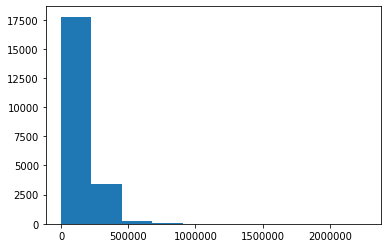

In [306]:
# распределение по доходу, похоже есть люди с доходом 2 млн, которые делают гистограмму менее информативной
plt.hist(df['total_income'])

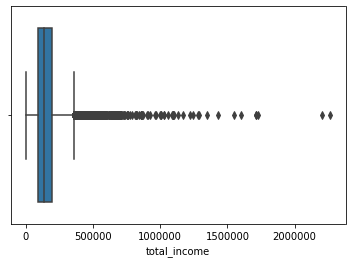

In [307]:
sb.boxplot(df['total_income'])

(array([2474., 4091., 5702., 4120., 2252., 1333.,  623.,  330.,  197.,
         110.]),
 array([     0. ,  49992.4,  99984.8, 149977.2, 199969.6, 249962. ,
        299954.4, 349946.8, 399939.2, 449931.6, 499924. ]),
 <a list of 10 Patch objects>)

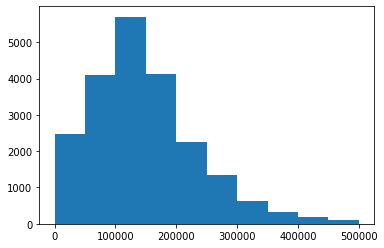

In [308]:
# доход до 500 000
plt.hist(df[df['total_income'] < 500000]['total_income'])

In [309]:
# делим на 3 равные по кол-ву категорий дохода, исключая при этом данныые с доходом = 0 (бывший Nan), т.к. мы не знаем к какой 
# категории дохода они реально относятся. 
# получатся такие группы низкий(20666.999, 116139.0] < средний(116139.0, 179528.0] < высокий(179528.0, 2265604.0]
df["income_category"] = pd.qcut(df[df['total_income'] != 0]['total_income'], 3,labels=["низкий", "средний", "высокий"])

In [310]:
# их равное кол-во
df['income_category'].value_counts()

средний    6451
низкий     6451
высокий    6449
Name: income_category, dtype: int64

In [311]:
# удалим столбец lemmas
df = df.drop(['lemmas'], axis=1)
df

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years,purpose_category,income_category
0,1,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,23,недвижимость,высокий
1,1,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,11,автомобиль,низкий
2,0,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,15,недвижимость,средний
3,3,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,11,образование,высокий
4,0,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,50,свадьба,средний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449,1,43,среднее,1,гражданский брак,1,f,компаньон,0,224791,операции с жильем,12,недвижимость,высокий
21450,0,67,среднее,1,женат / замужем,0,f,пенсионер,0,155999,сделка с автомобилем,50,автомобиль,средний
21451,1,38,среднее,1,гражданский брак,1,m,сотрудник,1,89672,недвижимость,5,недвижимость,низкий
21452,3,38,среднее,1,женат / замужем,0,m,сотрудник,1,244093,на покупку своего автомобиля,8,автомобиль,высокий


In [312]:
df['have_children'] = df['children'].apply(lambda n: False if n == 0 else True)
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,employed_years,purpose_category,income_category,have_children
0,1,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,23,недвижимость,высокий,True
1,1,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,11,автомобиль,низкий,True
2,0,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,15,недвижимость,средний,False
3,3,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,11,образование,высокий,True
4,0,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,50,свадьба,средний,False


**Вывод**

На основе лематизации разделили данные на 4 категории по цели на кредит. По уровню дохода данные были разделены на 3 равночисленные котегории - низкий, средний и высокий, т.к. если бы разделили их по категориям исходя из уровня принятого РОССТАТом, группы сильно различались бы по численности и были бы не релевантны.

<a id='3'></a>
## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [313]:
children_pivot = df.pivot_table(index='have_children', columns='debt', values='education', aggfunc='count')
children_pivot["ratio"] = children_pivot[1] / (children_pivot[0] + children_pivot[1])  * 100
children_pivot

debt,0,1,ratio
have_children,,,
False,13028,1063,7.543822
True,6685,678,9.208203


**Вывод**

**При отсутствии детей процент людей имевших задолженность составляет 7,5%. При их наличии же процент должников увеличивается. Причиной этому могут быть возросшие расходы на содержание семьи.**

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [314]:
family_pivot = df.pivot_table(index=['family_status_id', "family_status"], columns='debt', values='education', aggfunc='count')
family_pivot["ratio"] = family_pivot[1] / (family_pivot[0] + family_pivot[1])  * 100
family_pivot

,debt,0,1,ratio
family_status_id,family_status,,,
0,женат / замужем,11408,931,7.545182
1,гражданский брак,3763,388,9.347145
2,вдовец / вдова,896,63,6.569343
3,в разводе,1110,85,7.112971
4,не женат / не замужем,2536,274,9.750890


**Вывод**

Удивительно, но меньше других долги имела группа "вдовец / вдова". Самые рискованные же для банка неженатые и в гражданском браке.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [315]:
income_pivot = df.pivot_table(index=['income_category'], columns='debt', values='education', aggfunc='count')
income_pivot["ratio"] = income_pivot[1] / (income_pivot[0] + income_pivot[1])  * 100
income_pivot

debt,0,1,ratio
income_category,,,
низкий,5927,524,8.122772
средний,5886,565,8.758332
высокий,5967,482,7.474027


**Вывод**

**Средний класс оказался с наибольшими долгами. Самые надежные - люди с высоким доходом. Большую надежность людей с низким доходом относительно среднего обьяснить сложно, возможно они меньше берут кредиты.**

- Как разные цели кредита влияют на его возврат в срок?

In [316]:
purpose_pivot = df.pivot_table(index=['purpose_category'], columns='debt', values='education', aggfunc='count')
purpose_pivot["ratio"] = purpose_pivot[1] / (purpose_pivot[0] + purpose_pivot[1])  * 100
purpose_pivot

debt,0,1,ratio
purpose_category,,,
автомобиль,3903,403,9.359034
недвижимость,10029,782,7.233373
образование,3643,370,9.220035
свадьба,2138,186,8.003442


**Вывод**

**Наиболее надежными выглядят кредиты на недвижимость. Больший риск на другие цели можно объяснить тем, что эти операци менее объемные с точки зрения денежных средств, а следовательно критерии банка на их получение мягче, относительно недвижимости.**

<a id='4'></a>
## Шаг 4. Общий вывод


**Данные, полученные от банка для проведения анализа имели ряд недостатков. На этапе их предобработке мы столкнулись с пропуском  10% значений в данных о доходах и стаже, которые пришлось заполнить самостоятельно. Исправили аномальные (отрицательные) значения. Нашли и удалили как явные, так и неявные дупликаты, вызванные записью в разных регистрах. На основе данных о цели кредита провели их лемматизацию и выявили 4 основные соответствующие им категории (автомобиль, недвижемость, образование, свадьба). Так же провели категоризацию клиентов по наличию у них детей (есть или нет) и уровню дохода (высокий, средний, низкий), что позволило качественне провести анализ данных.**

**Рекомендации для улучшения качества сбора данных для последующего их анализа:**
- *придать уникальный id для каждого клиента, что поможет как анализу в целом, так и эффективнее выявлять дупликаты*
- *выявить причину и исправить искажения в данных (отрицательные числа и сверхвысокие значения стажа для пенсионеров)*
- *учет стажа работы вести в годах*
- *ввести единые требования по занесению данных в одном регистре*

**Рекомендации для улучшения показателей по возврату кредита и увеличению доходности банка.**

**Меньший риск невозврата средств имеют группы:**

* бездетные
* одинокие (разведенные, вдовы)
* с высоким доходом
* недвижимостью как целью кредита

**Таким образом наибольшим потенциалом для увеличения доходов банка можно считать увеличение операций с недвижимостью людей с высоким уровнем дохода, так как их выборки показывают наименьший риск невозврата кредита, при большем объеме денежных средста.**